In [1]:
import numpy as np
import pdb

from functools import reduce
from IPython.core.debugger import set_trace
from matplotlib import pyplot as plt
from matplotlib import rc
from numpy import random as rnd
from scipy.optimize import minimize
from scipy.stats import norm, multivariate_normal
from sklearn.neighbors import KernelDensity as kd

%matplotlib inline
rc('lines', linewidth=3)
rc('font', size=18)
rc('legend', fontsize=18)

In [2]:
# For reproducibility
rng = rnd.RandomState(1083463236)

In [3]:
# mixing proportions: 0.5 and 0.5
# mean0 = mean1 = 0
# sigma1 = 1
# sigma0: parameter of interest
sigma1 = 1
sigma0 = 4

# number of data points
# TODO: run code with n=100000 
n = 10000
num_z_samples = 100
# nu is the ratio of noise to data samples in NCE
nu = 1

# NCE

## Generate observed data and noise

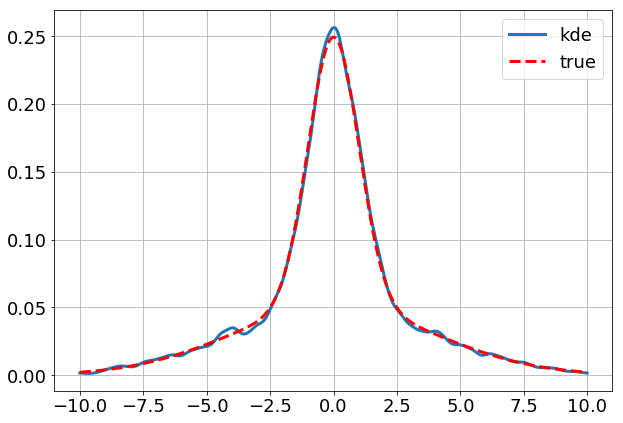

In [4]:
# observed data
z = rnd.uniform(0,1, n) > 0.5 
x = ((z==0)*(rnd.randn(n)*sigma0) + (z==1)*(rnd.randn(n)*sigma1)) 
# noise
y = sigma0 * rnd.randn(n*nu)

# check density
fig = plt.figure(figsize=(10,7))
u = np.arange(-10,10,0.01)

x_density = kd(bandwidth=0.2).fit(x.reshape(-1, 1))
x_density_samples = np.exp(x_density.score_samples(u.reshape(-1, 1)))
plt.plot(u, x_density_samples, label='kde')

px = 0.5*(norm.pdf(u,0,sigma0)+norm.pdf(u,0,sigma1))
plt.plot(u, px, label='true', c='r', linestyle = '--')

plt.legend()
plt.grid()

## NCE objective function 

In [5]:
thetas = np.arange(0.01, 8, 0.1)
n_theta = len(thetas)

# correctly normalised model
def pm(u, theta):
    return 0.5*(norm.pdf(u,0,theta) + norm.pdf(u, 0, sigma1))
# noise that matches the larger std
def pn(u):
    return norm.pdf(u,0, sigma0) 
# quick hack: generally better to work in log domain!
def h(u, theta):
    return np.log(pm(u, theta)) - np.log(pn(u))

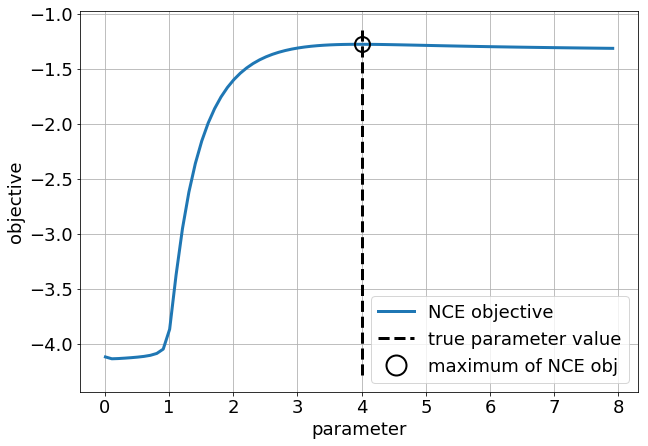

In [6]:
J = np.zeros(n_theta)
for k in range(n_theta):
    theta_k = thetas[k]
    a0 = 1 + nu*np.exp(-h(x,theta_k))
    a1 = 1 + (1/nu)*np.exp(h(y,theta_k))
    J[k] = -np.mean(np.log(a0)) - nu*np.mean(np.log(a1))

fig = plt.figure(figsize=(10,7))

plt.plot(thetas,J, label='NCE objective')
plt.plot(sigma0*np.array([1, 1]), plt.get(fig.gca(),'ylim'),'k--', label='true parameter value')

index = np.argmax(J)
plt.plot(thetas[index],J[index], marker='o', markersize=15, fillstyle='none', 
         markeredgewidth=2, c='k', linestyle='none', label='maximum of NCE obj')

plt.xlabel('parameter')
plt.ylabel('objective')

plt.grid()
lgd = plt.legend(loc='best', numpoints=1)
lgd.legendHandles[2]._legmarker.set_markersize(20)

## First lower bound (J1)

In [7]:
eps = 10**-15

#q0 = lambda u, alpha:  1 / (1 + (alpha/sigma1)*np.exp(-((u**2)/2)*(1/sigma1**2 - 1/alpha**2)))
def q0(u, alpha):
    a = norm.pdf(u, 0, alpha)
    b = norm.pdf(u, 0, sigma1)
    return a / (a + b)

def q1(u, alpha):
    return 1 - q0(u, alpha)

def phi0(u, theta):
    return 0.5*norm.pdf(u, 0, theta)

def phi1(u, theta):  
    return 0.5*norm.pdf(u, 0, sigma1)

def r0(u, theta, alpha):
    return phi0(u, theta)/( q0(u, alpha)*pn(u) + eps)

def r1(u, theta, alpha): 
    return phi1(u, theta)/( q1(u, alpha)*pn(u) + eps)

def r(u, z, theta, alpha):
    term1 = (z==0)*r0(u, theta, alpha)
    term2 = (z==1)*r1(u, theta, alpha)
    return term1 + term2

In [8]:
def compute_J1(x, y, zx, zy, theta, alpha):
    '''Compute J1 using a monte carlo estimate'''
    a = nu/(r(x, zx, theta, alpha) + eps) 
    first_term = -np.mean(np.log(1 + a))
    
    b = (1/nu) * np.mean(r(y, zy, theta, alpha), axis=0)
    second_term = -nu*np.mean(np.log(1 + b))
    
    return first_term + second_term

In [9]:
def sample_z(nz, x, y, alpha):
    """produces # samples equal to nz for each element of x & y"""
    zx = np.zeros((nz, len(x)))
    zy = np.zeros((nz, len(y)))
    for j in range(len(x)):
        zx[:,j] = rnd.uniform(0, 1, nz) < q1(x[j], alpha)
    for j in range(len(x)):
        zy[:,j] = rnd.uniform(0, 1, nz) < q1(y[j], alpha)  
    
    return zx, zy  # (nz, len(x)) , (nz, len(y))

In [10]:
J1_sigma0 = np.zeros(n_theta)
# generate 'missing data' using variational q distribution
zx, zy = sample_z(num_z_samples, x, y, sigma0)

for k in range(n_theta):
    theta_k = thetas[k]
    # compute the lower bound
    J1_sigma0[k] = compute_J1(x, y, zx, zy, theta_k, sigma0)

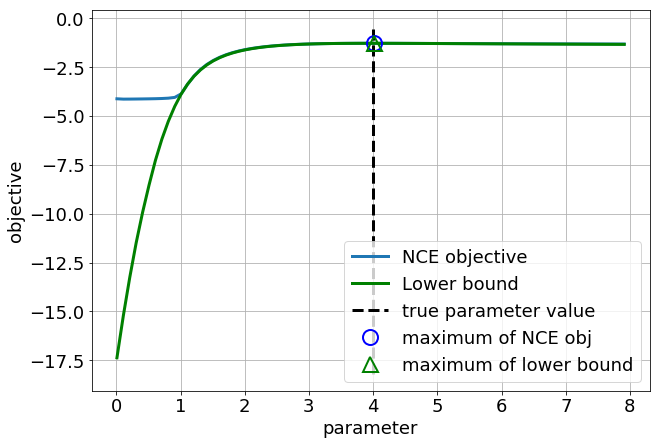

In [11]:
fig = plt.figure(figsize=(10, 7))
plt.plot(thetas, J, label='NCE objective')
plt.plot(thetas, J1_sigma0, 'g', label='Lower bound')

# true param value
plt.plot(sigma0 * np.array([1,1]), plt.get(fig.gca(),'ylim'), 'k--', label='true parameter value')

# maximiser of NCE obj
plt.plot(thetas[index],J[index], marker='o', markersize=15, fillstyle='none', 
         markeredgewidth=2, c='b', linestyle='none', label='maximum of NCE obj')

index2 = np.argmax(J1_sigma0)
# maximiser of lower bound
plt.plot(thetas[index2], J1_sigma0[index2], '^', markersize=15, fillstyle='none', 
         markeredgewidth=2, c='g', linestyle='none', label='maximum of lower bound')

"""
plt.plot(theta,Jlower,'g', label='lb w/o importance sampling')
index2 = np.argmax(Jlower)
# maximiser of lower bound (before importance sampling)
plt.plot(theta[index2], Jlower[index2], '^', markersize=15, fillstyle='none', 
         markeredgewidth=2, c='g', linestyle='none', label='max of lb w/o importance sampling')
"""

plt.xlabel('parameter')
plt.ylabel('objective')
plt.legend(loc='lower right', numpoints=1)
plt.grid()

In [12]:
print('J1 is a numerical lower bound for {}% of the parameters'.format(100* np.sum(J1_sigma0 < J) / J.size))

J1 is a numerical lower bound for 97.5% of the parameters


# Using EM-type procedure to maximize J1

## math

For a simple initial experiment, we will iterate between optimising $\theta$ (for a fixed q) to obtain $\theta_k$, and then resetting q to be:

$$ q_k := q(z=0 \ | \ u; \theta_k) = \left(  1 + \frac{\theta_k}{\sigma_1} \exp \left(\frac{- u^2}{2} \left( \frac{1}{\sigma_1^2} - \frac{1}{\theta_k^2} \right) \right) \right)^{-1} $$

Optimising $\theta$ involves maximising the lower bound on the NCE objective:

\begin{align}
J_1^k(\theta) = \color{red}{ - \mathbb{E}_{x} \mathbb{E}_{z \sim q_k} \left[ \log(1 + \frac{\nu}{r(x, z; \theta)}) \right]} - \color{blue}{ \nu \mathbb{E}_{y}  \left[ \log(1 + \frac{1}{\nu} \mathbb{E}_{z \sim q_k}[r(y, z; \theta)] ) \right]}
\end{align}

where 

$$ r(u,z, \theta) = \frac{\phi(u, z; \theta)}{q_k(z \ | \ u) p_y(u)}$$


Note that q here is *not* a function of theta.

To find the argmax of $J_1^K(\theta)$, we need to differentiate it. To do so, let us first further reduce the notational burden, by writing:

\begin{align}
J_1^k(\theta) & =  \color{red}{ - \mathbb{E}_{x} \mathbb{E}_{z \sim q_k} \left[ \log(\psi_1(x, z; \theta)) \right]} -       \color{blue}{ \nu \mathbb{E}_{y}  \left[  \log(\psi_2(y; \theta)) \right]} \\
\end{align}

Where the terms of the same colour are equivalent to each other.

Now, let us take derivative with respect to $\theta$:

\begin{align}
\color{red}{ \nabla_{\theta} \log(\psi_1(x, z; \theta))} & = \frac{1}{\psi_1(x, z; \theta)} \nabla_{\theta} \psi_1(x, z; \theta) \\
& = \frac{1}{\psi_1(x, z; \theta)} \frac{-\nu}{r(x, z; \theta)^2} \nabla_{\theta} r(x, z; \theta) \\
& = \frac{1}{\psi_1(x, z; \theta)} \frac{-\nu}{r(x, z; \theta)^2} \frac{\nabla_{\theta} \phi(x, z; \theta)}{q_k(z \ | \ x)p_y(x)}
\end{align}

Hence, we need:

\begin{align}
\nabla_{\theta} \phi(x, z; \theta) & = \nabla_{\theta} \exp ( \log ( \phi(x, z; \theta) ) ) \\
& = \left[ \nabla_{\theta} \log(\phi(x, z; \theta)) \right] \exp ( \log ( \phi(x, z; \theta) ) )\\
& = \left[ \nabla_{\theta} \left(-\log(\theta) - \frac{x^2}{2 \theta^2} \right) \right] \phi(x, z; \theta) \\
& = \left[ -\frac{1}{\theta} + \frac{x^2}{\theta^3} \right] \phi(x, z; \theta)
\end{align}

Plugging this back in, we get:

\begin{align}
\color{red}{ \nabla_{\theta} \log(\psi_1(x, z; \theta))} & = \frac{1}{\psi_1(x, z; \theta)} \frac{-\nu}{r(x, z; \theta)^2} \frac{\left[ -\frac{1}{\theta} + \frac{x^2}{\theta^3} \right] \phi(x, z; \theta)}{q_k(z \ | \ x)p_y(x)} \\
& = \frac{1}{\psi_1(x, z; \theta)} \frac{-\nu}{r(x, z; \theta)} \left[ -\frac{1}{\theta} + \frac{x^2}{\theta^3} \right] \\
& = \color{red}{-\nu \frac{\psi_1(x, z; \theta) - 1}{\psi_1(x, z; \theta)} \left[ -\frac{1}{\theta} + \frac{x^2}{\theta^3} \right]} \\
\end{align}

Where in the final line we used the fact that $\color{red}{\psi_1(x, z; \theta) - 1 = \frac{1}{r(x, z; \theta)}}$.

Now we find the derivative of the second (blue) term of $J_1^K(\theta)$. Recalling that $\color{blue}{\psi_2(y; \theta) = 1 + \frac{1}{\nu} \mathbb{E}_{z \sim q_k}[r(y, z; \theta)]}$, we have:

\begin{align}
\color{blue}{\nabla_{\theta} \log(\psi_2(y; \theta))} & = \frac{1}{\psi_2(y; \theta)} \nabla_{\theta} \psi_2(y; \theta) \\
& = \frac{1}{\psi_2(y; \theta)} \frac{1}{\nu} \mathbb{E}_{z \sim q_k} \left[ \frac{\nabla_{\theta} \phi(y, z; \theta)}{q_k(z \ | \ y)p_y(y)} \right] \\
& = \frac{1}{\psi_2(y; \theta)} \frac{1}{\nu} \mathbb{E}_{z \sim q_k} \left[ r(y, z; \theta) \left[ -\frac{1}{\theta} + \frac{y^2}{\theta^3} \right] \right] \\
& = \color{blue}{\frac{\psi_2(y; \theta) - 1}{\psi_2(y; \theta)} \left[ -\frac{1}{\theta} + \frac{y^2}{\theta^3} \right]}
\end{align}

Putting this all together, we arrive at: 

\begin{align}
\nabla_{\theta}(J_1^k(\theta)) & =  \color{red}{\nu \mathbb{E}_{x} \mathbb{E}_{z \sim q_k} \frac{\psi_1(x, z; \theta) - 1}{\psi_1(x, z; \theta)} \left[ -\frac{1}{\theta} + \frac{x^2}{\theta^3} \right]} + \color{blue}{ -\nu \mathbb{E}_{y}  \frac{\psi_2(y; \theta) - 1}{\psi_2(y; \theta)} \left[ -\frac{1}{\theta} + \frac{y^2}{\theta^3} \right]} \\
\end{align}

To avoid numerical stability issues (due to the division by $\theta^3$), let's reparameterise $\theta = \exp(\gamma)$. the gradient w.r.t $\gamma$ is:

\begin{align}
\nabla_{\gamma}(J_1^k(\gamma)) & =  \color{red}{\nu \mathbb{E}_{x} \mathbb{E}_{z \sim q_k} \frac{\psi_1(x, z; \exp(\gamma)) - 1}{\psi_1(x, z; \exp(\gamma))} \left[x^2 \exp(-2\gamma)- 1 \right]} + \color{blue}{ -\nu \mathbb{E}_{y}  \frac{\psi_2(y; \exp(\gamma)) - 1}{\psi_2(y; \exp(\gamma))} \left[y^2 \exp(-2 \gamma) - 1\right]} \\
\end{align}

## code

In [13]:
def psi_1(x, z, theta, alpha):
    return 1 + (1 / r(x, z, theta, alpha))

def psi_2(y, z, theta, alpha):
    return 1 + (1/nu)* np.mean(r(y, z, theta, alpha), axis=0)

In [14]:
def J1_grad(x, y, zx, zy, theta, alpha):
    '''Computes J1_grad as defined in the equations above'''
    a = (psi_1(x, zx, theta, alpha) - 1)/psi_1(x, zx, theta, alpha)
    term_1 = nu*np.mean(a*(-(1/theta) + (x**2/theta**3)))
    
    b = (psi_2(y, zy, theta, alpha) - 1)/psi_2(y, zy, theta, alpha)
    term_2 = -nu*np.mean(b*(-(1/theta) + (y**2/theta**3)))
    
    return term_1 + term_2

In [29]:
def maximize_J1_wrt_theta(X, Y, ZX, ZY, theta):
    
    J1_k_neg = lambda t: -compute_J1(X, Y, ZX, ZY, t, t)
    J1_k_grad_neg = lambda t: -np.array([J1_grad(X, Y, ZX, ZY, t, t)])

    res = minimize(J1_k_neg, theta, method='BFGS', jac=J1_k_grad_neg,
                   options={'disp': True})
    new_theta = res.x
    return new_theta

In [31]:
theta0 = np.array([1])
stop_threshold = 10**-9

ZX, ZY = sample_z(num_z_samples, x, y, theta0)
J1_0 = compute_J1(x, y, ZX, ZY, theta0, theta0)

thetas_after_em_step = [theta0]  # save list of thetas for each em step
J1s = [J1_0]  # save values of lower bound for each function eval during optimisation

prev_J1, current_J1 = -999, -9999  # arbitrary negative numbers
theta = theta0
while np.abs(prev_J1 - current_J1) > stop_threshold:
    prev_J1 = compute_J1(x, y, ZX, ZY, theta, theta)
    theta = maximize_J1_wrt_theta(x, y, ZX, ZY, theta)

    ZX, ZY = sample_z(num_z_samples, x, y, theta)
    current_J1 = compute_J1(x, y, ZX, ZY, theta, theta)

    # store results
    thetas_after_em_step.append(theta)
    J1s.append(current_J1)

         Current function value: 1.381459
         Iterations: 8
         Function evaluations: 108
         Gradient evaluations: 97
         Current function value: 1.279291
         Iterations: 3
         Function evaluations: 86
         Gradient evaluations: 74
         Current function value: 1.279291
         Iterations: 0
         Function evaluations: 87
         Gradient evaluations: 75


Above, we (hopefully) generated successively better lower bounds to the NCE objective function. Let's evaluate these functions on a range of values and then plot them.

In [32]:
lower_bounds = [np.zeros(n_theta) for i in range(len(thetas_after_EM_step))]
for i in range(len(lower_bounds)):
    # final theta after one EM step
    theta_k = thetas_after_EM_step[i]
    
    # generate 'missing data' using q defined by theta_k
    zx, zy = sample_z(num_z_samples, x, y, theta_k)
    
    # plot J1 as a function of theta
    for j in range(n_theta):
        # compute lower bound
        lower_bounds[i][j] = compute_J1(x, y, zx, zy, thetas[j], theta_k)

## plots

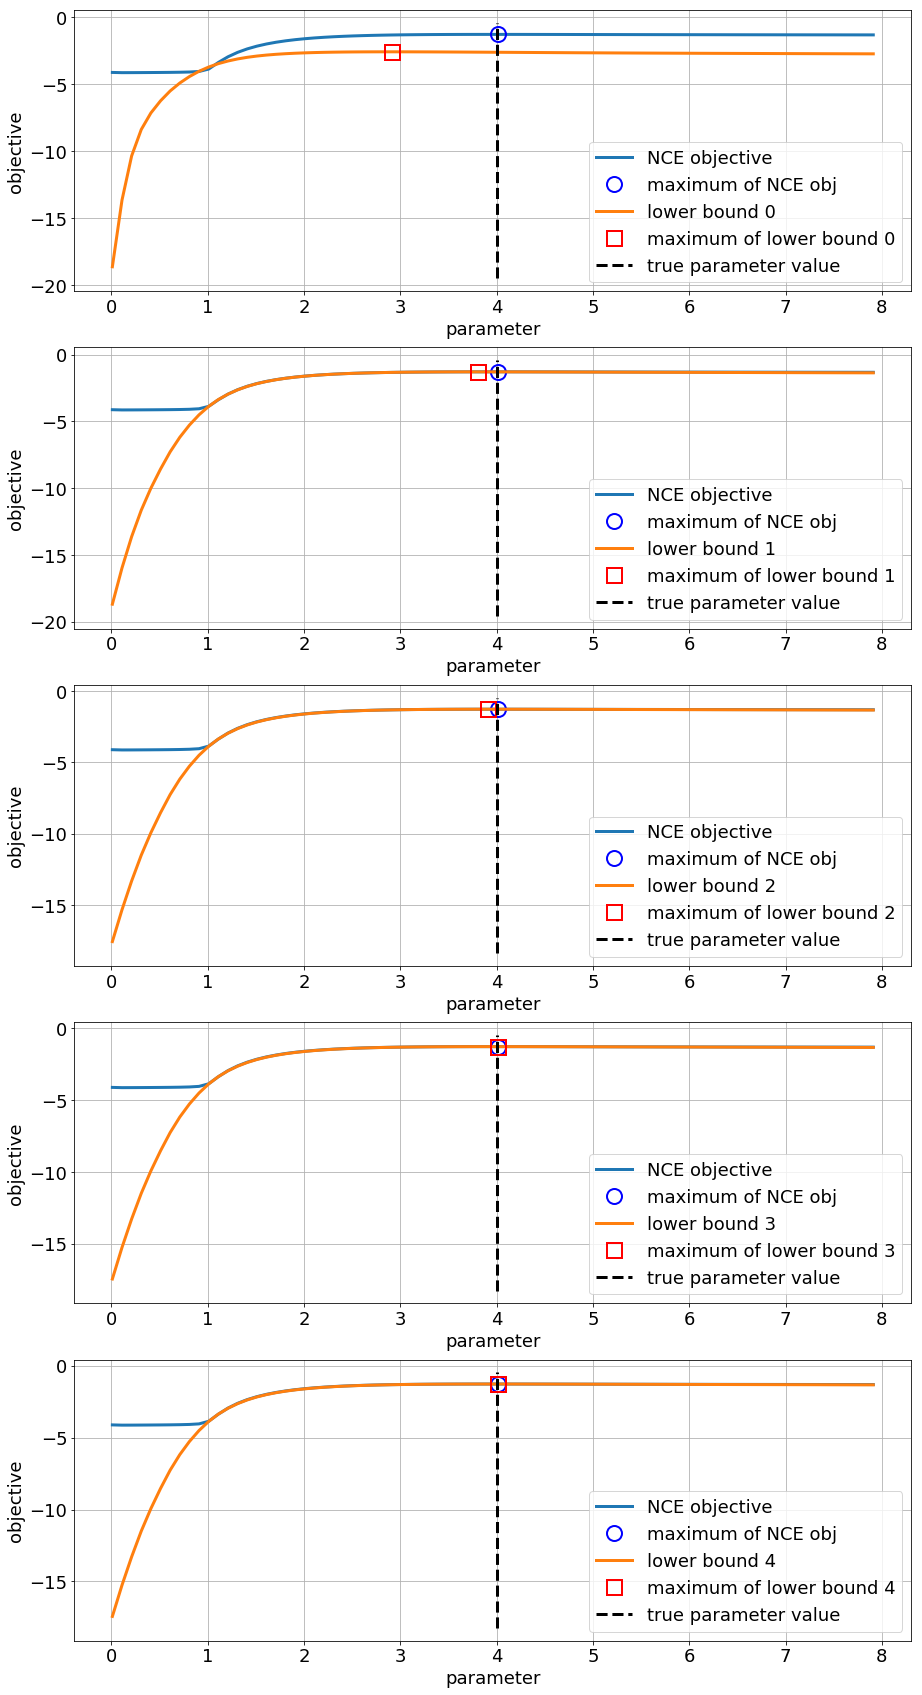

In [33]:
fig, axs = plt.subplots(len(lower_bounds), 1, figsize=(15, 30))
axs = axs.ravel()
for i in range(len(lower_bounds)):
    
    # plot NCE objective and its maximum
    axs[i].plot(thetas, J, label='NCE objective')
    axs[i].plot(thetas[index],J[index], marker='o', markersize=15, fillstyle='none', 
         markeredgewidth=2, c='b', linestyle='none', label='maximum of NCE obj')
    
    lb = lower_bounds[i]
    axs[i].plot(thetas, lb, label='lower bound {}'.format(i))
   
    # maximiser of lower bound
    lb_index = np.argmax(lb)
    axs[i].plot(thetas[lb_index], lb[lb_index], 'rs', markersize=15, fillstyle='none', 
             markeredgewidth=2, linestyle='none', label='maximum of lower bound {}'.format(i))
    
    # true param value
    axs[i].plot(sigma0 * np.array([1,1]), plt.get(axs[i],'ylim'), 'k--', label='true parameter value')

    axs[i].set_xlabel('parameter')
    axs[i].set_ylabel('objective')
    axs[i].legend(loc='lower right', numpoints=1)
    axs[i].grid()